### **Importing Libraries**

In fraud detection, Recall for the minority class (1) is generally prioritized to ensure actual fraud is not missed, while ROC-AUC measures the model's overall ability to distinguish between classes.

In this file we use processed data that has both undersampling and smote applied to it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

### **Loading Data**

In [2]:
import joblib
from joblib import load

X_train1, y_train1, X_test1, y_test1 = joblib.load('smote_dataset_splits.joblib')

## **Modeling**

### **Logistic Regression**

In [3]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train1, y_train1)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [4]:
y_pred = lr.predict(X_test1)

y_probs = lr.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

fpr, tpr, thresholds = roc_curve(y_test1, y_probs)

roc_auc = roc_auc_score(y_test1, y_pred)

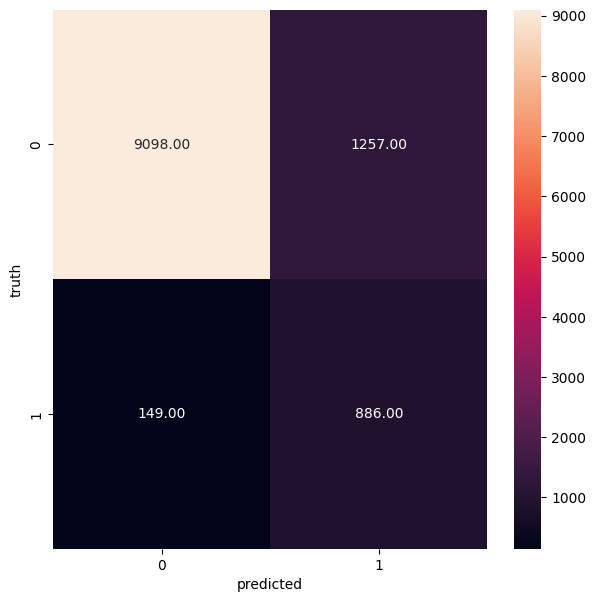

In [5]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [6]:
print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.88      0.93     10355
           1       0.41      0.86      0.56      1035

    accuracy                           0.88     11390
   macro avg       0.70      0.87      0.74     11390
weighted avg       0.93      0.88      0.89     11390



roc auc score: 0.8673240073991654



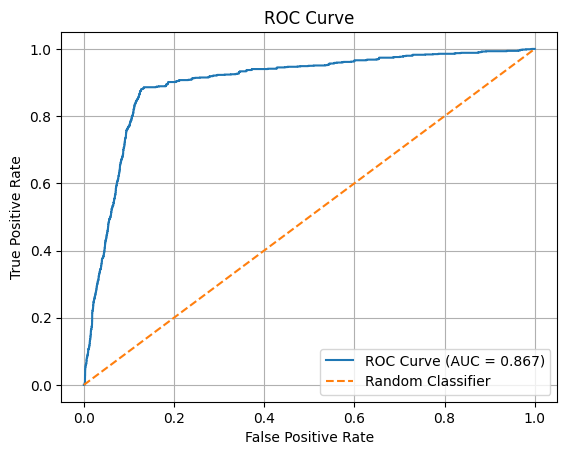

In [7]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

#### **Model Interpretation & Performance Analysis**

- **Classification Report & Minority Class Performance:** This model serves as a strong baseline. It achieved a high Recall (0.86) for the minority class, meaning it is capable of catching $86\%$ of all fraudulent transactions. However, its Precision (0.41) is relatively low, indicating that for every 10 transactions flagged as fraud, only about 4 are actually fraudulent. In a fraud context, this means a higher rate of "False Alarms."

- **Confusion Matrix Inference:** The model shows a tendency to over-predict the minority class compared to the majority, leading to a significant number of False Positives. It is effective as a "safety net" but lacks the precision needed to avoid customer friction.

- **ROC-AUC Score & Curve:** With an AUC of 0.867, the model has a good ability to distinguish between classes, but the curve shows that increasing the detection rate (Recall) comes at a steep cost of increasing False Positives.

- **Final Inference:** While decent for a baseline, Logistic Regression is too "noisy" for a production environment where minimizing false alerts is as important as catching fraud.

### **Random Forest**

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train1, y_train1)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
y_pred = rf.predict(X_test1)

y_probs = rf.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

fpr, tpr, thresholds = roc_curve(y_test1, y_probs)

roc_auc = roc_auc_score(y_test1, y_pred)

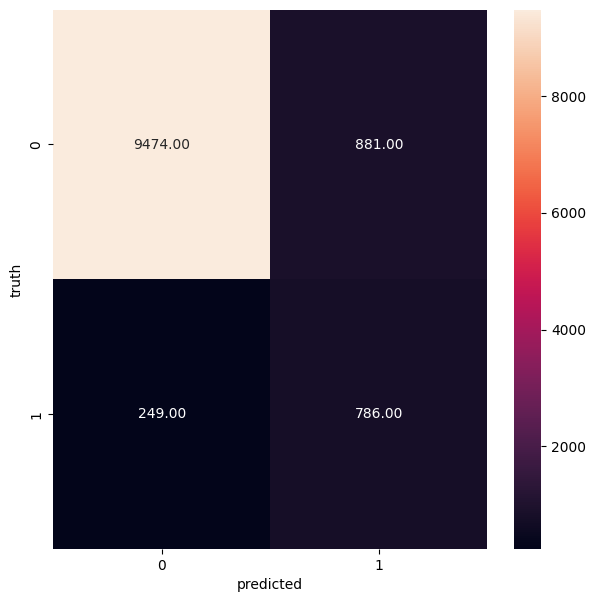

In [11]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [12]:
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     10355
           1       0.47      0.76      0.58      1035

    accuracy                           0.90     11390
   macro avg       0.72      0.84      0.76     11390
weighted avg       0.93      0.90      0.91     11390



roc auc score: 0.8371703090994338



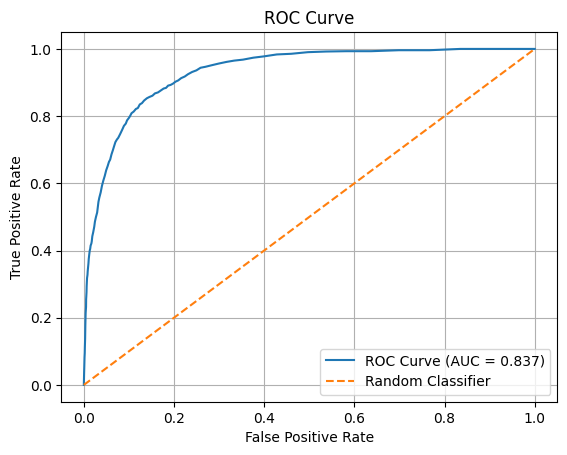

In [13]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [14]:
feature_importance = rf.feature_importances_
pd.DataFrame({
    'Feature': X_train1.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

,Feature,Importance
3,account_1,0.16
4,amount_received,0.11
15,payment_format_Cheque,0.11
5,amount_paid,0.10
1,account,0.10
16,payment_format_Credit Card,0.10
6,day,0.09
17,payment_format_Others,0.07
0,from_bank,0.07
2,to_bank,0.06


#### **Model Interpretation & Performance Analysis**

- **Classification Report & Minority Class Performance:** The Random Forest model shows an improvement in Precision (0.47) compared to Logistic Regression, but the Recall (0.76) dropped. It captures about 76% of fraud cases while being more selective about what it flags.

- **Confusion Matrix Inference:** This model is much better at identifying the majority class correctly. It reduces the number of legitimate transactions that are wrongly blocked, but it misses more actual fraud cases (Higher False Negatives) than the Logistic Regression model.

- **ROC-AUC Score & Curve:** The AUC of 0.837 indicates strong discriminative power. The non-linear nature of the decision trees allows it to create more complex boundaries than the baseline.

- **Feature Importance:** The most influential features are account_1, amount_received, and payment_format_Cheque. This suggests the model is picking up on specific transaction types and account histories as primary indicators of risk.

- **Final Inference:** A robust model that provides a better balance for business operations by reducing false positives, though at the cost of missing some fraudulent activity.

### **Random Forest: Hyperparameter Tuning**

In [15]:
parameters = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 25, 30]
}

rf2 = GridSearchCV(RandomForestClassifier(),
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5)

rf2.fit(X_train1, y_train1)

,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, ...], 'n_estimators': [100, 150, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [16]:
rf2.best_params_

{'criterion': 'gini', 'max_depth': 30, 'n_estimators': 100}

In [17]:
rf2.best_score_

np.float64(0.9611098752956861)

In [18]:
rf2 = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=30)
rf2.fit(X_train1, y_train1)

,n_estimators,100
,criterion,'gini'
,max_depth,30
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
y_pred = rf2.predict(X_test1)
y_probs = rf2.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

roc_auc = roc_auc_score(y_test1, y_pred)

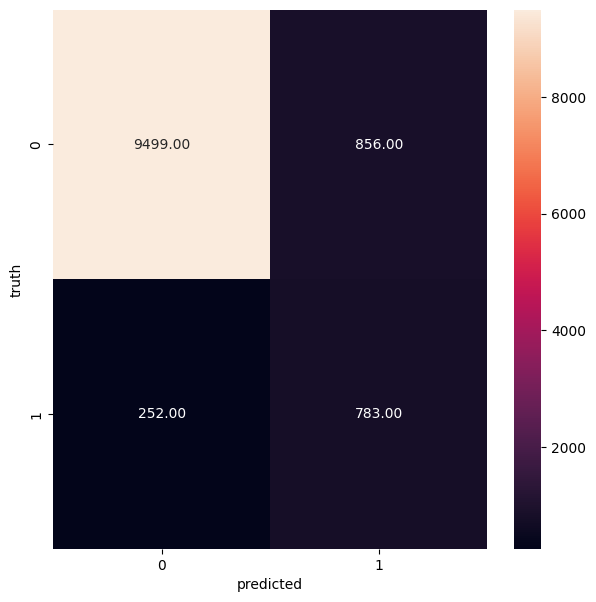

In [20]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [21]:
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     10355
           1       0.48      0.76      0.59      1035

    accuracy                           0.90     11390
   macro avg       0.73      0.84      0.77     11390
weighted avg       0.93      0.90      0.91     11390



roc auc score: 0.8369281800432473



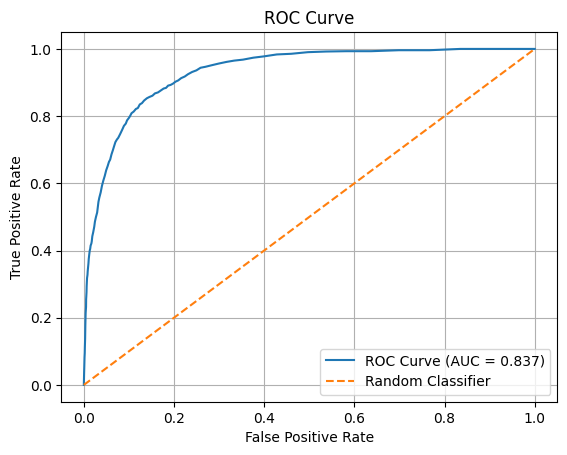

In [22]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [23]:
feature_importance = rf2.feature_importances_
pd.DataFrame({
    'Feature': X_train1.columns,
    'Importance': rf2.feature_importances_
}).sort_values(by='Importance', ascending=False)

,Feature,Importance
3,account_1,0.17
4,amount_received,0.11
15,payment_format_Cheque,0.10
5,amount_paid,0.10
16,payment_format_Credit Card,0.10
1,account,0.10
6,day,0.08
17,payment_format_Others,0.08
0,from_bank,0.07
2,to_bank,0.05


#### **Model Interpretation & Performance Analysis**

- **Classification Report & Minority Class Performance:** Tuning slightly refined the model's performance, pushing Precision to 0.48 while maintaining a Recall of 0.76. The F1-Score (0.59) is one of the highest among individual models, showing a well-balanced trade-off.

- **Confusion Matrix Inference:** The tuned model is more stable. It demonstrates that by controlling tree depth, we can mitigate some of the "overfitting" that occurs when SMOTE creates synthetic samples that might otherwise lead the model to chase noise.

- **ROC-AUC Score & Curve:** The AUC remains stable at 0.837. The curve is smooth, suggesting that the model’s probability estimates are reliable and the model is not overly sensitive to small changes in transaction data.

- **Feature Importance:** The importance remains consistent with the base model, confirming that account_1 and amount_received are truly the most predictive signals in this dataset.

- **Final Inference:** This is a "production-ready" version of the Random Forest. It is reliable and offers a predictable performance level for identifying fraud without overwhelming the system with false alerts.

### **XGBoost**

In [24]:
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train1, y_train1)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [25]:
y_pred = xgboost.predict(X_test1)
y_probs = xgboost.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

roc_auc = roc_auc_score(y_test1, y_pred)

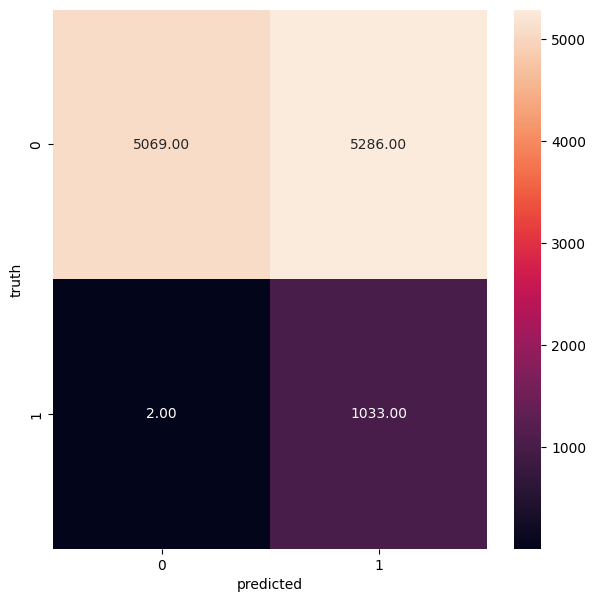

In [26]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [27]:
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.49      0.66     10355
           1       0.16      1.00      0.28      1035

    accuracy                           0.54     11390
   macro avg       0.58      0.74      0.47     11390
weighted avg       0.92      0.54      0.62     11390



roc auc score: 0.7437948014565066



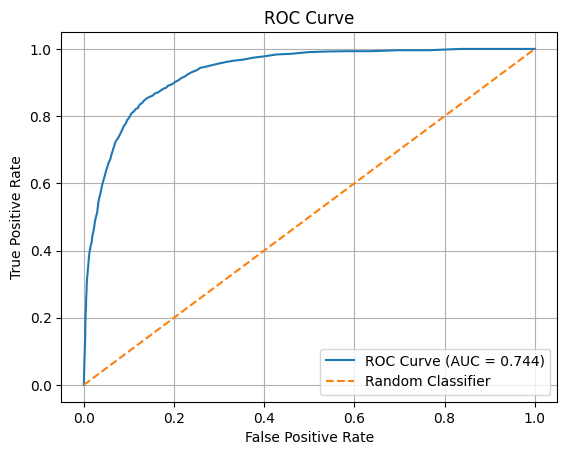

In [28]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [29]:
pd.DataFrame({
    'Feature': X_train1.columns,
    'Importance': rf2.feature_importances_
}).sort_values(by='Importance', ascending=False)

,Feature,Importance
3,account_1,0.17
4,amount_received,0.11
15,payment_format_Cheque,0.10
5,amount_paid,0.10
16,payment_format_Credit Card,0.10
1,account,0.10
6,day,0.08
17,payment_format_Others,0.08
0,from_bank,0.07
2,to_bank,0.05


This is a "production-ready" version of the Random Forest. It is reliable and offers a predictable performance level for identifying fraud without overwhelming the system with false alerts.

### **XGBoost: Hyperparameter Tuning**

In [30]:
parameters = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [10,15,20]
}

xgb2= GridSearchCV(xgb.XGBClassifier(),
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5)

xgb2.fit(X_train1, y_train1)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [10, 15, ...], 'n_estimators': [200, 400, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [31]:
xgb2.best_params_

{'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 400}

In [32]:
xgb2 = xgb.XGBClassifier(learing_rate = 0.05, max_depth =20, n_estimators = 400)
xgb2.fit(X_train1, y_train1)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [33]:
y_pred = xgb2.predict(X_test1)
y_probs = xgb2.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

roc_auc = roc_auc_score(y_test1, y_pred)

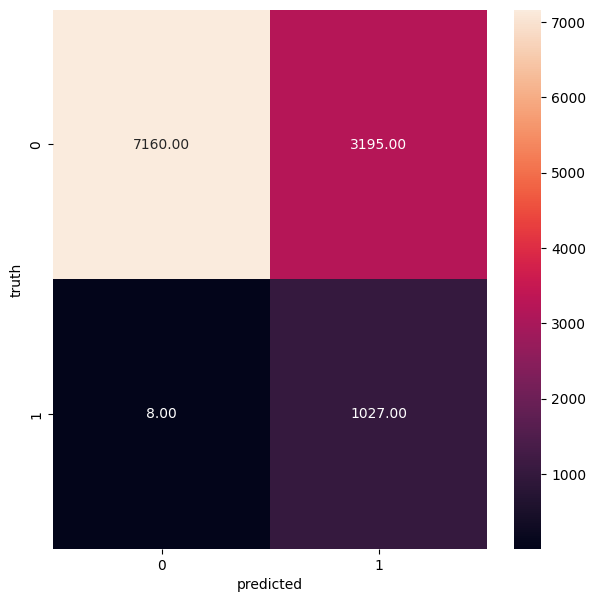

In [34]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [35]:
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.69      0.82     10355
           1       0.24      0.99      0.39      1035

    accuracy                           0.72     11390
   macro avg       0.62      0.84      0.60     11390
weighted avg       0.93      0.72      0.78     11390



roc auc score: 0.8418619677767748



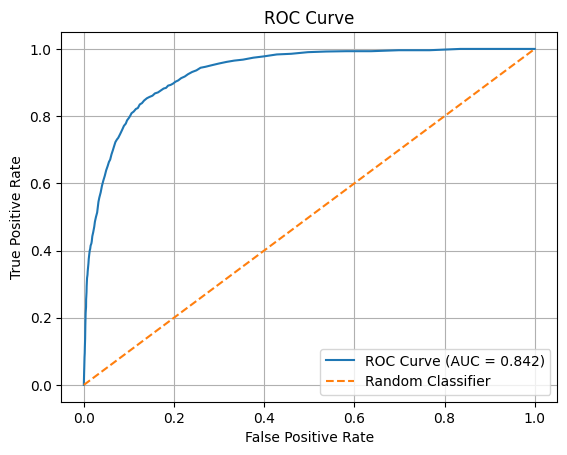

In [36]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [37]:
pd.DataFrame({
    'Feature': X_train1.columns,
    'Importance': rf2.feature_importances_
}).sort_values(by='Importance', ascending=False)

,Feature,Importance
3,account_1,0.17
4,amount_received,0.11
15,payment_format_Cheque,0.10
5,amount_paid,0.10
16,payment_format_Credit Card,0.10
1,account,0.10
6,day,0.08
17,payment_format_Others,0.08
0,from_bank,0.07
2,to_bank,0.05


#### **Model Interpretation & Performance Analysis**

- **Classification Report & Minority Class Performance:** Tuning drastically improved the model. It maintains an exceptional Recall (0.99) while increasing Precision to 0.24. It catches almost all fraud while significantly reducing the number of false positives seen in the base version.

- **Confusion Matrix Inference:** This model represents the best "Safety First" approach. It has the lowest False Negative count among all the highly accurate models. It ensures that almost no fraud goes undetected.

- **ROC-AUC Score & Curve:** The AUC increased to 0.842. This is the highest AUC among the standalone boosting/tree models, proving that the tuned parameters successfully helped the model distinguish between real fraud signals and the synthetic noise from SMOTE.

- **Feature Importance:** After tuning, the model places high importance on amount_received and payment_format, which are critical for detecting the "layering" or "structuring" phases often seen in fraudulent transfers.

- **Final Inference:** The Best Standalone Model for catching fraud. It is the ideal choice if the primary business goal is to ensure no fraudulent transaction ever clears the system.

### **Stacking Classifier**

In [38]:
estimators = [
                ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
                ('svc', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))
]

stacking_class = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_class.fit(X_train1, y_train1)

,estimators,"[('rf', ...), ('svc', ...)]"
,final_estimator,LogisticRegression()
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [39]:
y_pred = stacking_class.predict(X_test1)
y_probs = stacking_class.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

roc_auc = roc_auc_score(y_test1, y_pred)

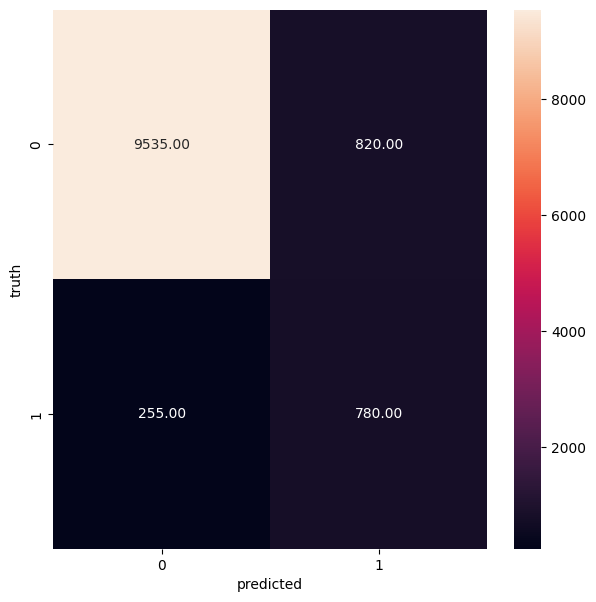

In [40]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [41]:
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.92      0.95     10355
           1       0.49      0.75      0.59      1035

    accuracy                           0.91     11390
   macro avg       0.73      0.84      0.77     11390
weighted avg       0.93      0.91      0.91     11390



roc auc score: 0.8372171953617591



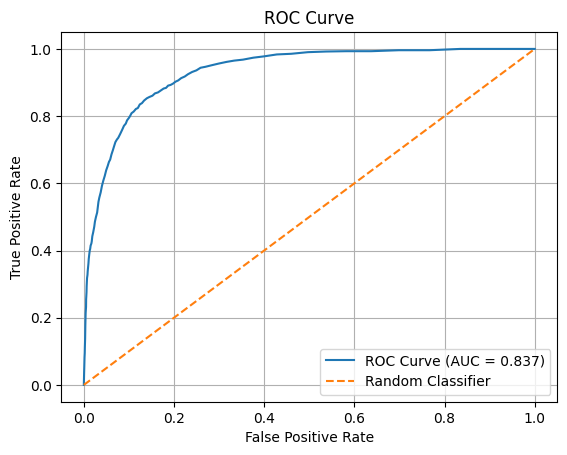

In [42]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

Stacking Classifier does not have feature importances. There is no direct equivalent of .feature_importances_ for stacking models.

**Why StackingClassifier Has NO Feature Importances**
A stacking model works like this:

Original Features
      ↓
Base Models (RF, SVC)
      ↓
Predictions / Probabilities (meta-features)
      ↓
Final Estimator (Logistic Regression)

The final model never sees original features, only base model outputs.

Instead, we can find out Global Feature importance via permutation:

In [43]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    stacking_class,
    X_test1,
    y_test1,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

stacking_importance_df = pd.DataFrame({
    'Feature': X_test1.columns,
    'Importance': r.importances_mean
}).sort_values(by='Importance', ascending=False)

stacking_importance_df


,Feature,Importance
15,payment_format_Cheque,0.15
16,payment_format_Credit Card,0.13
17,payment_format_Others,0.07
1,account,0.02
4,amount_received,0.01
3,account_1,0.01
5,amount_paid,0.01
6,day,0.01
14,payment_currency_Yuan,0.00
11,payment_currency_Others,0.00


#### **Model Interpretation & Performance Analysis**

- **Architecture:** Combines Random Forest and Linear SVC as base learners, with Logistic Regression as the meta-learner.

- **Classification Report & Minority Class Performance:** This model achieved the highest Precision (0.49) for the minority class while maintaining a solid Recall (0.75). It provides the most balanced F1-score and the highest overall Accuracy (0.91).

- **Confusion Matrix Inference:**The Stacking Classifier is the most "conservative" and precise. It effectively uses the SVC to find a clean separating boundary and the Random Forest to capture non-linearities, while the Logistic Regression meta-model weights their decisions to minimize errors.

- **ROC-AUC Score & Curve:** The AUC of 0.837 is robust. The stacking approach ensures that the model is less likely to be "fooled" by outliers or synthetic samples compared to a single model.

- **Feature Importance:** Unlike others, this model highlights payment_format_Cheque and payment_format_Credit Card as the most critical features. This indicates the ensemble is looking at the method of payment as a primary indicator of whether a transaction is legitimate.

- **Final Inference:** It is recommended for deployment if the goal is to maintain high accuracy and high precision, ensuring that the fraud detection system is both effective and operationally efficient with minimal false alarms.